# 데이콘 소득 예측 경진대회 EDA

- 예측이지만, binary classification 문제
- 간단한 EDA와 변수 가공
- NA처리와 패턴 분석을 주로 수행.

# 변수 설명

```
id : 샘플 아이디
age : 나이
workclass : 일 유형
fnlwgt : CPS(Current Population Survey) 가중치 (이 사람이 표본에 뽑힐 가능성에 따른 가중치. 높을수록 뽑히기 어려운 사람?)
education : 교육수준
education.num : 교육수준 번호
marital.status : 결혼 상태
occupation : 직업
relationship : 가족관계
race : 인종
sex : 성별
capital.gain : 자본 이익 (부동산, 토지, 주식 등)
capital.loss : 자본 손실
hours.per.week : 주당 근무시간
native.country : 본 국적
target : 소득
					   0 = <=50K (5만 달러 이하)

					   1 = >50K (5만 달러 초과) 
```


- 이를 통해 생각한 가설들.
    - 'education'과 'education.num' 둘 중 하나만 사용면되는 dummi 변수로 생각된다.
    - 'workclass'와 'occupation'이 둘다 비어있는 경우, 백수로 취급하고 level을 추가해도 된다.(workclass na와 occupation na가 같은지)
    - sample submit 결과, target의 불균형이 크다. stratified kfold를 사용을 고려한다.
    - 나이도 더미변수로 활용해 보는 것이 좋아보인다.
    - 본 국적은 제거해도 상관없다고 생각한다. (선형회귀 후, 검정을 통해 판단하려고함.)




In [4]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import sys

In [50]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

# 데이터 확인

In [3]:
# 파일 불러오기
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
#submission = pd.read_csv('./data/sample_submission.csv')

In [6]:
train

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


In [7]:
test

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,47,Private,304133,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
1,1,34,Self-emp-inc,154227,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,75,United-States
2,2,31,Local-gov,158291,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,8614,0,40,United-States
3,3,28,Private,183155,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
4,4,54,Local-gov,182543,Some-college,10,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,30,Local-gov,182926,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,40,United-States
15077,15077,39,Private,176101,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
15078,15078,48,Private,242406,11th,7,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,Puerto-Rico
15079,15079,44,Private,100584,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States


In [12]:
# 데이터 차원 확인하기
print('train : ',train.shape)
print("test : ", test.shape)

train :  (17480, 16)
test :  (15081, 15)


## 타입 체크


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              17480 non-null  int64 
 1   age             17480 non-null  int64 
 2   workclass       15644 non-null  object
 3   fnlwgt          17480 non-null  int64 
 4   education       17480 non-null  object
 5   education.num   17480 non-null  int64 
 6   marital.status  17480 non-null  object
 7   occupation      15637 non-null  object
 8   relationship    17480 non-null  object
 9   race            17480 non-null  object
 10  sex             17480 non-null  object
 11  capital.gain    17480 non-null  int64 
 12  capital.loss    17480 non-null  int64 
 13  hours.per.week  17480 non-null  int64 
 14  native.country  16897 non-null  object
 15  target          17480 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.1+ MB


- 3컬럼 정도가 na가 있음을 알 수있다.
- 그리고 가설에서 예상했던 것처럼, workclass가 na면 ocupation도 na일 가능성이 높아보인다. (백수예상)

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education.num   15081 non-null  int64 
 6   marital.status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital.gain    15081 non-null  int64 
 12  capital.loss    15081 non-null  int64 
 13  hours.per.week  15081 non-null  int64 
 14  native.country  15081 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.7+ MB


In [24]:
np.sum(test.isna())
#test set에는 na는 없다.

id                0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

# 범주형 level 확인

In [18]:
print('workclass \n',train['workclass'].unique())
print('education \n',train['education'].unique())
print('marital.status \n',train['marital.status'].unique())
print('occupation \n',train['occupation'].unique())
print('relationship \n',train['relationship'].unique())
print('race \n',train['race'].unique())
print('sex \n',train['sex'].unique())
print('native.country \n',train['native.country'].unique())

workclass 
 ['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay' nan 'Never-worked']
education 
 ['Assoc-acdm' 'Some-college' 'Bachelors' 'HS-grad' 'Prof-school' '10th'
 '11th' 'Masters' '7th-8th' '1st-4th' 'Assoc-voc' '5th-6th' 'Doctorate'
 '9th' '12th' 'Preschool']
marital.status 
 ['Married-civ-spouse' 'Never-married' 'Divorced' 'Separated'
 'Married-AF-spouse' 'Married-spouse-absent' 'Widowed']
occupation 
 ['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces' nan]
relationship 
 ['Husband' 'Own-child' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race 
 ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex 
 ['Male' 'Female']
native.country 
 ['United-States' 'Poland' 'Mexico' 'Ireland' 'Guatemala'
 'Dominican-Republic' 'Greece' 'El-

## NA 체크

- dacon sample 함수 사용

In [13]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: workclass 입니다
해당 컬럼에 총 1836 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: occupation 입니다
해당 컬럼에 총 1843 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: native.country 입니다
해당 컬럼에 총 583 개의 결측치가 존재합니다.


결측치가 있는 row들을 확인.

In [14]:
# 결측치가 있는 row들을 확인합니다.
train[train.isna().sum(axis=1) > 0]

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
15081,15081,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
15082,15082,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
15083,15083,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,1
15084,15084,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,1
15085,15085,22,Private,119592,Assoc-acdm,12,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,2824,40,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


In [58]:
train[train['occupation']=='Other-service']

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
8,8,17,Local-gov,39815,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,0
16,16,28,Private,191027,Assoc-acdm,12,Separated,Other-service,Not-in-family,White,Male,0,0,40,United-States,0
25,25,20,Private,280714,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,0
53,53,44,Private,279183,Some-college,10,Married-civ-spouse,Other-service,Own-child,White,Female,0,0,40,United-States,1
54,54,25,Private,66622,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17335,17335,50,Private,205100,7th-8th,4,Married-civ-spouse,Other-service,Wife,White,Female,0,0,35,NaN,0
17352,17352,41,Private,192779,7th-8th,4,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,NaN,0
17357,17357,18,Private,174926,9th,5,Never-married,Other-service,Own-child,White,Male,0,0,15,NaN,0
17406,17406,26,Private,261203,7th-8th,4,Never-married,Other-service,Unmarried,Other,Female,0,0,30,NaN,0


가설확인을 위해 workclass와 occupation 둘다 na인 행 출력

In [26]:
type1= train['workclass'].isna()
type2= train['occupation'].isna()

two_na=train[type1&type2]
two_na

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
15081,15081,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
15082,15082,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
15084,15084,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,1
15086,15086,61,NaN,135285,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,2603,32,United-States,0
15087,15087,71,NaN,100820,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,2489,15,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


예상과 다르게, 결혼도 안했고 workclass&occupation이 na인데도( two_na ) 고소득층이 존재.

이런 경우가 진짜 NA값이라 생각해서 제거해주거나 패턴을 확인.

더 자세히 분석하기위해, two_na데이터를 target에 따라 feature 별 시각화.

In [33]:
two_na_cate = two_na.drop(['id','workclass','occupation', 'age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'],axis = 1) #범주형이 아닌 피쳐 drop
two_na_cate.head()

,education,marital.status,relationship,race,sex,native.country,target
15081,HS-grad,Widowed,Not-in-family,White,Female,United-States,0
15082,Some-college,Widowed,Unmarried,Black,Female,United-States,0
15084,Doctorate,Never-married,Not-in-family,White,Male,United-States,1
15086,HS-grad,Married-civ-spouse,Husband,White,Male,United-States,0
15087,HS-grad,Married-civ-spouse,Husband,White,Male,United-States,0


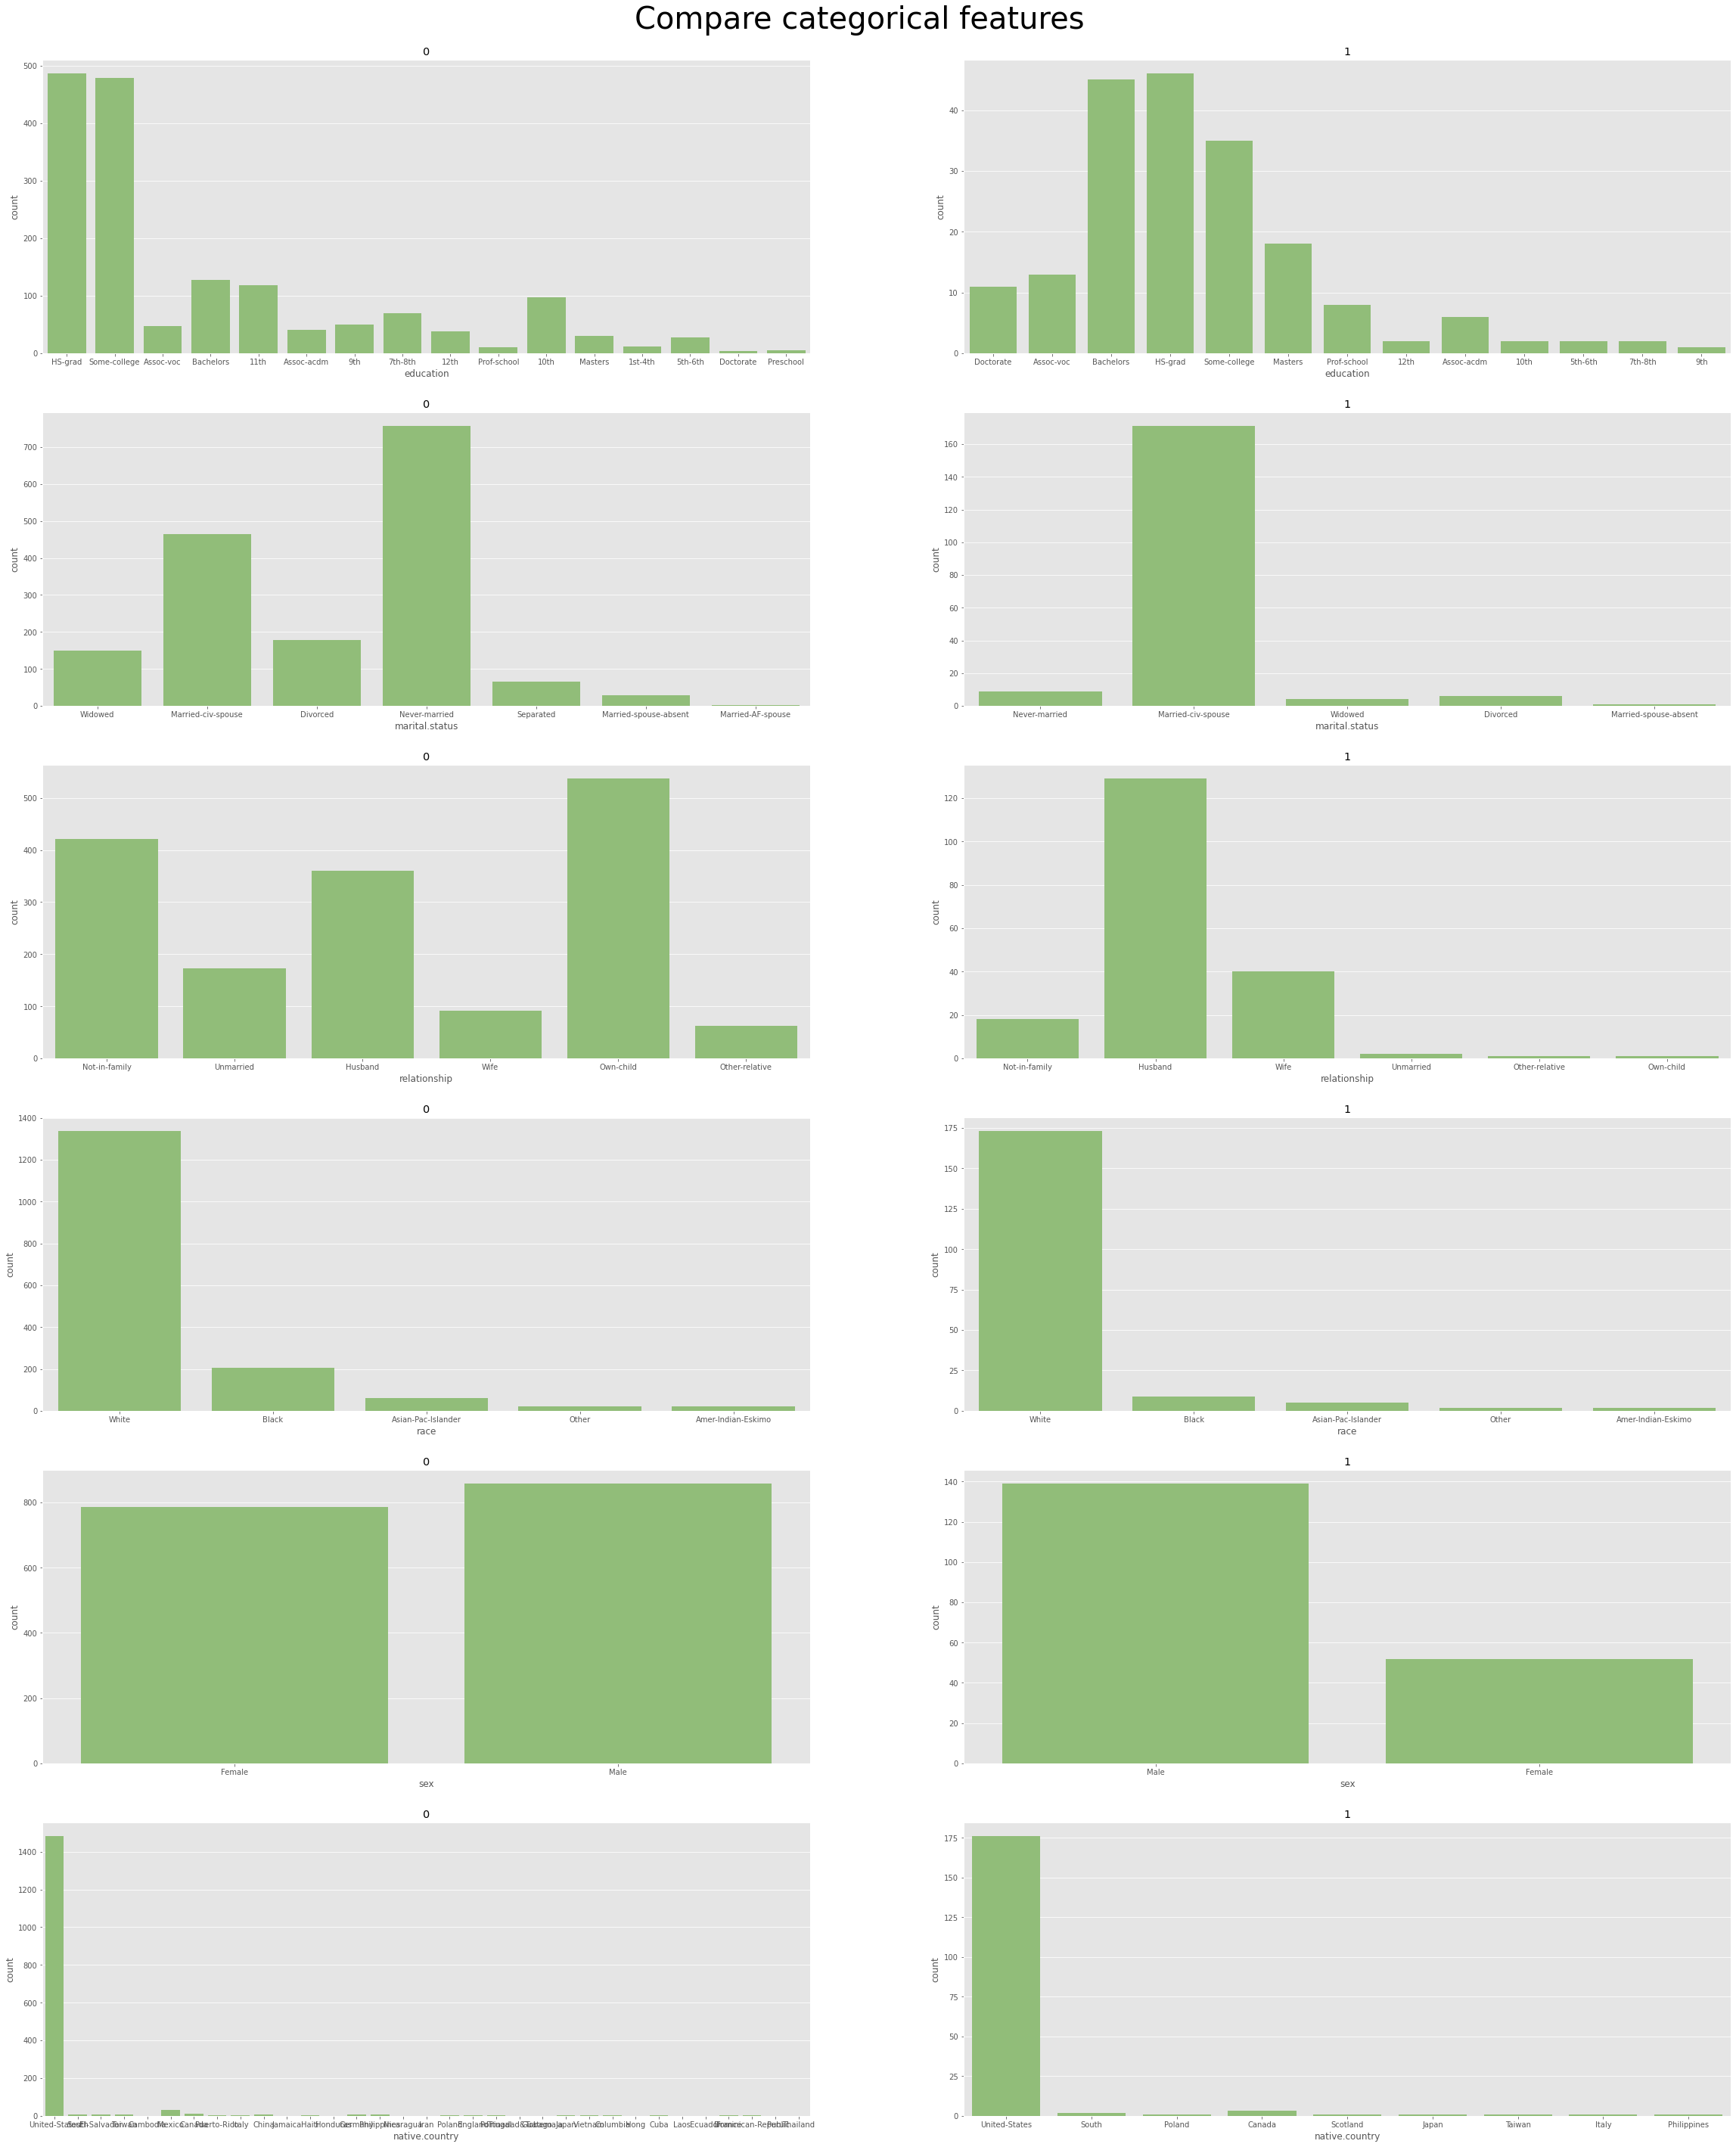

In [49]:
# 범주형 데이터 분포
def visualize(axx, field, num): ##그래프를 그리기 위한 메소드
    sns.countplot(x=two_na_cate.columns[num], data=two_na_cate[two_na_cate['target'] == field],  color='#8ec96d', ax = axx) # countplot을 이용하여 그래프를 그려줍니다.
    axx.set_title(field)

figure, ((ax1,ax2),(ax3,ax4), (ax5, ax6),(ax7, ax8), (ax9, ax10),
         (ax11,ax12))  = plt.subplots(nrows=6, ncols=2) ## 원하는 개수의 subplots 만들어주기
figure.set_size_inches(40, 50) #(w,h)
figure.suptitle('Compare categorical features', fontsize=40, y = 0.9)

k = 0 # 피쳐 수
j = 1 # 그래프 수
while k<6: 
    for i in range(0,2):
        visualize(eval(f'ax{j}'), two_na_cate['target'].unique()[i], k)
        j = j+1
    k = k+1

<AxesSubplot:title={'center':'capital gain and marriage'}, xlabel='marital.status', ylabel='capital.gain'>

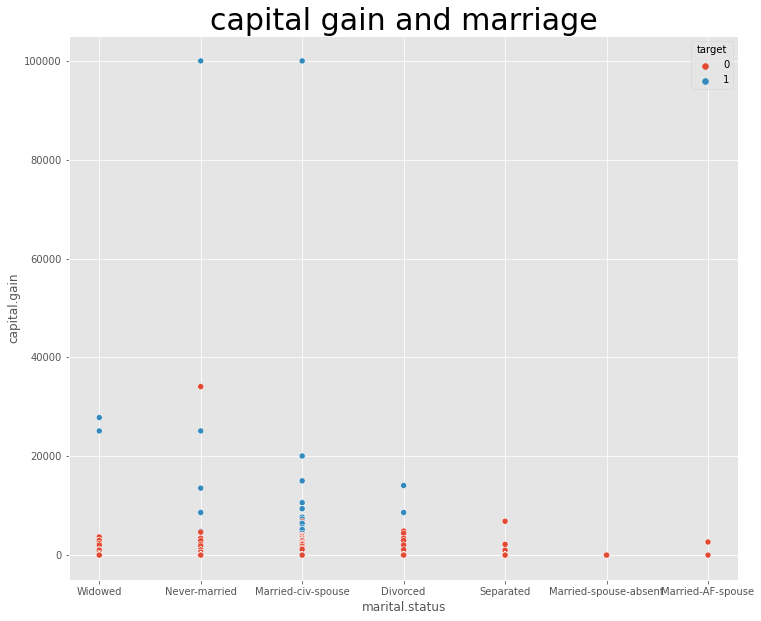

In [54]:
two_na_cate = two_na.drop(['id','workclass','occupation', 'age', 'fnlwgt', 'education.num', 'hours.per.week'],axis = 1) #범주형이 아닌 피쳐 drop

plt.figure(figsize=(12, 10))
plt.title('capital gain and marriage', fontsize = 30)
sns.scatterplot(x = 'marital.status',y= 'capital.gain', hue= 'target', data= two_na_cate)

two_na 고소득자(target==1) 중에서, gain을 확인해본 결과,

married를 제외하고, capital gain이 50k 이하인 것은 제거하는 것이 옳다고 보인다.(직업을 알 수 없는 경우이다.)

In [ ]:
train.describe()

## 본 국적 확인

본 국적에 na값이 많으니, 선형회귀를 통해 나라에 따라 영향이 있는지 검정하려고함.

<AxesSubplot:title={'center':'native.country and age'}, xlabel='native.country', ylabel='age'>

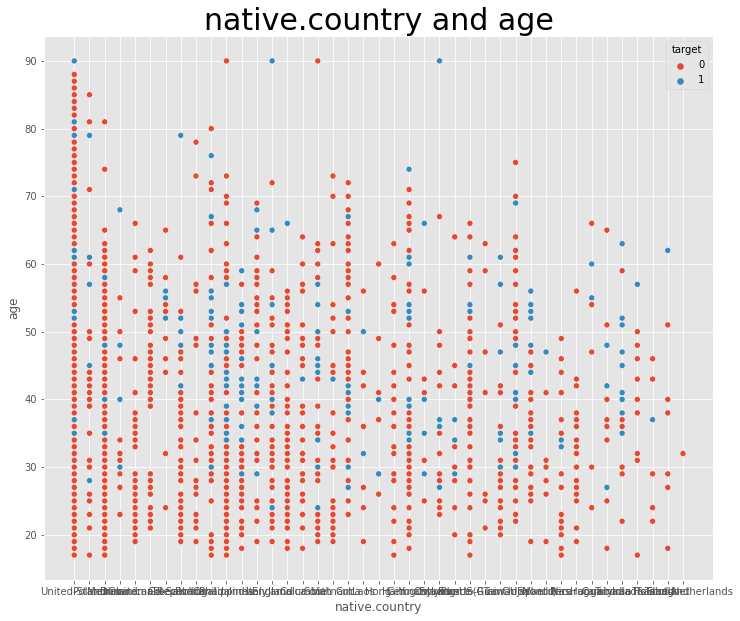

In [62]:
plt.figure(figsize=(12, 10))
plt.title('native.country and age', fontsize = 30)
sns.scatterplot(x = 'native.country',y= 'age',hue='target' ,data= train)

# 수치형 데이터 분포 확인

# 변수 가공

앞에서 찾은 인사이트들로, 변수 가공을 수행


In [ ]:
#NA 처리

In [ ]:
#education num 제거

In [ ]:
#나이데이터 수정.

# 결론


1. workclass &  occupation이 둘다 na인 경우, 상황에따라 제거하거나 without_payment, occupation : baeksu 라는 level을 만들어 삽입해주었다.
2. education과 education.num은 education.num만 남겼다. 
3. 나이 데이터를 수치형에서 범주형으로 변경. 특정 나이대에 따라 소득 여부가 확실히 보이기 때문.
4. 국적데이터 컬럼을 제거했다.